2.467417806465668


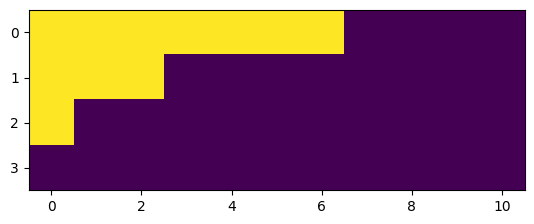

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import random


class AccessControlQueue:
    def __init__(self) -> None:
        self.state = (10, random.choice(range(4)))
    
    def state_shape(self):
        return (11, 4)
    
    def action_shape(self):
        return 2
    
    def reset(self):
        self.state = (10, random.choice(range(4)))
        return self.state
    
    def step(self, action):
        num_free_server = self.state[0]

        for _ in range(10 - num_free_server):
            if random.random() < 0.06:
                num_free_server += 1

        client_priority = [1,2,4,8][self.state[1]]
        if 0 == action and num_free_server > 0:
            reward = client_priority
            num_free_server -= 1
        else:
            reward = 0

        #if reward:
        #    print(num_free_server, reward)
        self.state = (num_free_server, random.choice(range(4)))
        return reward, self.state

class ActionValueTable:
    def __init__(self, env):
        state_shape = env.state_shape()
        action_shape = env.action_shape()
        qs_shape = state_shape + (action_shape,)
        self.qs = np.zeros(qs_shape)

    #def predicate(self, state, action):
    #    return self.qs[state, action]
    
    def predicate(self, state):
        return self.qs[state]
    
    def train(self, state, action, delta, alpha):
        self.qs[state][action] += alpha * delta

def epsilon_greedy(qs, epsilon):
    if random.random() < epsilon:
        return random.choice(range(len(qs)))
    else:
        #ismaxs = qs.max() == qs
        #indices = [i for i in range(len(qs)) if ismaxs[i]]
        #return np.random.choice(indices)#slow
        return qs.argmax()
    

def differential_semi_gradient_sarsa(env, value_function, num_steps, alpha = 0.01, beta = 0.01, epsilon = 0.1):
    avg_reward = 0
    state = env.reset()
    qs = value_function.predicate(state)
    action = epsilon_greedy(qs, epsilon)
    for step in range(num_steps):
        reward, next_state = env.step(action)
        next_qs = value_function.predicate(next_state)
        next_action = epsilon_greedy(next_qs, epsilon)
        delta = reward - avg_reward + next_qs[next_action] - qs[action]
        #if step % 10000 == 0:
        #    print(delta,reward,avg_reward,next_qs[next_action],qs[action])
        avg_reward += beta * delta
        value_function.train(state, action, delta, alpha)
        state = next_state
        action = next_action
        qs = next_qs
        
    print(avg_reward)

env = AccessControlQueue()
value_function = ActionValueTable(env)
differential_semi_gradient_sarsa(env, value_function, 10000000)
#value_function.qs.argmax(axis=2)
plt.imshow(value_function.qs.argmax(axis=2).T)
